In [ ]:
#IMPORT DATA=====================================================================================================================

In [203]:
import torch
import numpy as np
import random
import pandas as pd
from pandas import DataFrame as df
import torch.nn as nn
import torch.nn.functional as F
import math
from matplotlib import pyplot as plt
import torch_geometric
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
import networkx as nx
import dgl
import dgl.nn as dglnn
import dgl.function as fn
import itertools
import scipy.sparse as sp
import dgl.function as fn

import sys

import networkx as nx

import argparse
import os

import tensorflow as tf
from tensorflow.python.keras import layers
from tensorflow import keras
from scipy.sparse.linalg import svds,eigsh
from scipy.sparse import csc_matrix

import re

import scipy.interpolate

from scipy.linalg import block_diag

from torch.utils.data import DataLoader

from sklearn.metrics import roc_auc_score


from scipy.spatial.distance import pdist, squareform
from torch.nn.parameter import Parameter
import torch.optim as optim
import time
from sklearn.metrics import f1_score
import ipdb

import copy

import multiprocessing as mp
import functools


random.seed(25252)


In [220]:

#pickle
import pickle

with open('inputs/simulated_p_values.pickle', 'rb') as handle:
    p_values_genome = pickle.load(handle)
    
with open('inputs/simulated_effect_sizes.pickle', 'rb') as handle:
    genome_effect_sizes = pickle.load(handle)
    
with open('inputs/simulated_annotations.pickle', 'rb') as handle:
    annotations = pickle.load(handle)
    
with open('inputs/simulated_ld_blocks.pickle', 'rb') as handle:
    ld_blocks = pickle.load(handle)
    
with open('inputs/simulated_causal_variants.pickle', 'rb') as handle:
    causal_variants = pickle.load(handle)
    
with open('inputs/simulated_causal_genes.pickle', 'rb') as handle:
    causal_genes = pickle.load(handle)

with open('inputs/simulated_causal_genes_to_snps.pickle', 'rb') as handle:
    num_causal_snps = pickle.load(handle)
    
with open('inputs/simulated_networks.pickle', 'rb') as handle:
    networks = pickle.load(handle)

In [221]:
#summary statistics
genome_end = int(ld_blocks.loc[len(ld_blocks)-1, "end"])
genome_start = int(ld_blocks.loc[0, "start"])
genome_length = int(genome_end - genome_start)

summary_statistics_data = {'chromosome': [1]*genome_length, 'bp': range(genome_start, genome_end), 'p_value': p_values_genome}
summary_statistics = pd.DataFrame(data=summary_statistics_data)


#networks
networks_list = list(networks.items())
networks_list = [list(y) for x,y in networks_list]
networks_list = [x for x,y in networks_list]
networks = []
networks.append(networks_list)

In [222]:
causal_genes #delete me

['RP11-542C10.1',
 'MORN1',
 'CDK11B',
 'LINC00982',
 'CEP104',
 'ACOT7',
 'AL645728.2',
 'RP11-58A11.2']

/var/folders/7j/329_cmn56qz2jnvgvylvq3dm0000gn/T/ipykernel_4169/626270350.py:5: RuntimeWarning: divide by zero encountered in log10
  neg_log_p_values = -1*np.log10(p_values_genome)


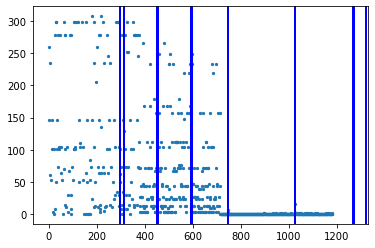

In [223]:
#plot p values
import matplotlib.pyplot as plt


neg_log_p_values = -1*np.log10(p_values_genome)


plt.scatter(range(len(neg_log_p_values)), neg_log_p_values, s = 5)
vert_line_pos = [int(e[3:]) for e in causal_variants] #[i for i, e in enumerate(['snp' + str(num1) for num1 in range(n_snps)]) if e in causal_variants]
for position in vert_line_pos:
    plt.axvline(x = position, color = 'b', label = 'axvline - full height')
# plt.show()
plt.savefig('simulated_p_values.png')

In [224]:
#SUMMARY STATISTICS (output: summary_statistics)
summary_statistics = summary_statistics.set_index('bp', drop = False)

summary_statistics['p_value'] = summary_statistics['p_value'].fillna(1)
annotations = annotations.reset_index()
networks = networks
ld_blocks = ld_blocks
networks_input_networks = ['simlated_network']
prior_causal_genes = causal_genes[0:5]
lower_non_causal_p_value_threshold = 1e-5
upper_causal_p_value_threshold = 1e-5
encoder_ratio_denominator = 16

In [7]:
#NETWORKS (output: networks)

In [8]:
#PREPROCESSING

In [9]:
# #========================================================================================================================================================================
# summary_statistics = summary_statistics[summary_statistics['chromosome'].isin([22])].reset_index(drop=True)
# annotations = annotations[annotations['chromosome'].isin([22])].reset_index(drop=True)
# annotations = annotations[1:15000]
# networks
# ld_blocks = ld_blocks[ld_blocks['chromosome'].isin([22])].reset_index(drop=True)
# # number_of_networks = len(networks)
# networks_input_networks = ['corum', 'kegg']
# prior_causal_genes =  ['LA16c-4G1.4', 'LA16c-4G1.5', 'NBEAP3', 'LA16c-60H5.7', 'AC007064.24']
# lower_non_causal_p_value_threshold = 0.5
# upper_causal_p_value_threshold = 0.90
# # gene_list = list(annotations['gene_name'].unique())
# # chromosome_list = list(annotations['chromosome'].unique())
# encoder_ratio_denominator = 16


In [10]:
# summary_statistics_to_plot = copy.deepcopy(summary_statistics)
# summary_statistics_to_plot['p_value_log10'] = -1*np.log10(summary_statistics_to_plot['p_value'])
# summary_statistics_to_plot.plot(x='bp', y='p_value_log10', style='o')


In [44]:
#CONDENSE_ANNOTATIONS

def condense_annotations(annotations):
    """
    Argument(s):
    annotations: a dataframe with columns <chromosome, annotation, start, end, gene_{feature; e.g., name, strand, type}>
    """

    #MERGE ANNOTATIONS

    #columns in annotaion dataframe
    annotation_columns = list(annotations.columns.values)
    #remove start and end column names
    annotation_columns_no_positions = [e for e in annotation_columns if e not in ('start', 'end')]
    #group annotations dataframe by all gene features (all column names besides start and end) and find minimum start and maximum end value, condense all groups into one row with min start and max end values
    annotations_out = annotations.groupby(annotation_columns_no_positions).agg({'start':'min', 'end':'max'})
    #sort by chromosme first then start position
    annotations_out = annotations_out.sort_values(['chromosome', 'start'], ascending=[True, True]).reset_index()


    return annotations_out

In [45]:
annotations = condense_annotations(annotations).reset_index()


In [46]:
# annotations = condense_annotations(annotations)

In [47]:
#FILTER NETWORK GENES

def filter_network_genes(networks, annotations):
    new_networks = []

    #for each network
    for network in networks:
        #all genes in the annotation file
        eligible_genes = list(annotations['gene_name'])

        #only keep genes that are in the annotation file
        network_genes_eligible = [list(filter(lambda a: a in eligible_genes, network[i])) for i in range(0, len(network))]

        #remove all empty lists
        network_genes_eligible_cleaned = [x for x in network_genes_eligible if x]
        #remove all lists of length 1 (since we cant connect anything together with 1 gene)
        network_genes_eligible_cleaned = [lst for lst in network_genes_eligible_cleaned if len(lst) != 1]

        #get all unique networks (removce duplicate networks left after filtering)
        basis_networks = set(tuple(x) for x in network_genes_eligible_cleaned)
        network_genes_eligible_cleaned = [ list(x) for x in basis_networks ]
        
        #append to master list
        new_networks.append(network_genes_eligible_cleaned)
        
    return new_networks

In [48]:
# networks = filter_network_genes(networks, annotations)



In [49]:
#EDGE CONNECTIONS (source, destinastion format)

In [50]:
#('gene', 'gene_of', 'network_2_pathway')
#('gene', 'gene_of', 'network_1_pathway')

def generate_gene_of_edges(networks, gene_list):

    #list to store lists of souce and destinstion nodes for each network type
    list_of_gene_of_source_gene = []
    list_of_gene_of_destination_pathway = []

    #for each network type inputted
    for network_type in networks:

        #list to store souce and destinstion nodes for this network type
        gene_of_source_gene = []
        gene_of_destination_pathway = []

        #for each network and gene, check if the gene resides in the network
        for network_index in range(0, len(network_type)):
            for gene_index in range(0, len(gene_list)):
                if gene_list[gene_index] in network_type[network_index]:
                    #append gene index (in and gene_list) and network index (in networks[networrk type index])
                    gene_of_source_gene.append(gene_index)
                    gene_of_destination_pathway.append(network_index)

        #append this network types list to the master list
        list_of_gene_of_source_gene.append(gene_of_source_gene)
        list_of_gene_of_destination_pathway.append(gene_of_destination_pathway)
        
    return list_of_gene_of_source_gene, list_of_gene_of_destination_pathway
    
    


In [51]:
# list_of_gene_of_source_gene, list_of_gene_of_destination_pathway = generate_gene_of_edges(networks, gene_list)


In [52]:
#('gene', 'network_1', 'gene')
#('gene', 'network_2', 'gene')


def generate_network_edges(networks, gene_list):


    #list to store lists of souce and destinstion nodes for each network type
    list_of_network_source_gene = []
    list_of_network_distination_gene = []



    #for each network type inputted
    for network_type in networks:

        #list to store souce and destinstion nodes for this network type
        network_source_gene = []
        network_distination_gene = []

        #for each network
        for network in network_type:
            #find all indices of the genes in this network
            list_gene_indices = [i for i in range(len(gene_list)) if gene_list[i] in network]
            #get all unique combinations of pairs of elements (we want a fully connected network of genes)
            unique_combinations_forward = list(itertools.combinations(list_gene_indices, 2))
            #make bidirectional edges by getting reverse of all tuples of sources and destinations
            unique_combinations_backward = [t[::-1] for t in unique_combinations_forward]
            #all unique combinations
            unique_combinations = unique_combinations_forward + unique_combinations_backward

            #get source and destination node indexed from tuples
            sources = [i for (i, j) in unique_combinations]
            destinations = [j for (i, j) in unique_combinations]

            #append to source and destination list
            network_source_gene.append(sources)
            network_distination_gene.append(destinations)

        #flatten out lists of sources and destinations
        network_source_gene = [x for xs in network_source_gene for x in xs]
        network_distination_gene = [x for xs in network_distination_gene for x in xs]



        #append this network types list to the master list
        list_of_network_source_gene.append(network_source_gene)
        list_of_network_distination_gene.append(network_distination_gene)

    return list_of_network_source_gene, list_of_network_distination_gene
    



In [53]:
# list_of_network_source_gene, list_of_network_distination_gene = generate_network_edges(networks, gene_list)

In [54]:
#('region', 'region_of', 'gene')

def generate_region_of_edges(gene_list, annotations):

    #list to store lists of souce and destinstion nodes
    region_of_source_region = []
    region_of_distination_gene = []

    #for each gene
    for gene_index in range(0, len(gene_list)):
        #find all associated gene regions with the gene
        list_region_indices = [i for i in range(len(annotations)) if annotations.loc[i, 'gene_name'] == gene_list[gene_index]]
        #destination gene is just this gene (for all matching gene regions)
        list_gene_indices = [gene_index] * len(list_region_indices)

        #append to source and destination list
        region_of_source_region.append(list_region_indices)
        region_of_distination_gene.append(list_gene_indices)

    #flatten out lists of sources and destinations
    region_of_source_region = [x for xs in region_of_source_region for x in xs]
    region_of_distination_gene = [x for xs in region_of_distination_gene for x in xs]
    
    return region_of_source_region, region_of_distination_gene





In [55]:
# region_of_source_region, region_of_distination_gene = generate_region_of_edges(gene_list, annotations)

In [56]:
#('region', 'same_gene', 'region')

def generate_same_gene_edges(annotations):

    #make a matrix with comparison of True if gene names match and False if gene names do not match
    same_gene_comparison_matrix = annotations['gene_name'].values == annotations['gene_name'].values[:, None]
    #fill diagonals with False to prevent self linking (since any gene region with always have the same gene as itself)
    np.fill_diagonal(same_gene_comparison_matrix, False)
    #array of lists 
    same_gene_array_of_indices = np.argwhere(same_gene_comparison_matrix)

    #get source and destination node indexed from array
    same_gene_source_region = [row[0] for row in same_gene_array_of_indices]
    same_gene_destination_region = [row[1] for row in same_gene_array_of_indices]
    
    return same_gene_source_region, same_gene_destination_region




In [57]:
# same_gene_source_region, same_gene_destination_region = generate_same_gene_edges(annotations)

In [58]:
#('region', 'overlapping', 'region')

def generate_overlapping_edges(annotations, chromosome_list):

    list_overlapping_comparison_matrices = []

    #for each chromosome (since overlapping regions cannot be on the same chromosome
    for chromosome_n in chromosome_list:

        #create a subset of annottaions corresposding to this choromosome
        annotations_chromosome_n = annotations[annotations['chromosome'] == chromosome_n].reset_index(drop=True)


        #construct empty comparison matrix of dimension [number of gene regions x number of gene regions]
        overlapping_comparison_matrix = np.full((len(annotations_chromosome_n), len(annotations_chromosome_n)), False)
        #for each pair of gene regions
        for i, j in itertools.product(range(0, len(annotations_chromosome_n)), range(0, len(annotations_chromosome_n))):
            #if either/or:
            #the start site of one region lies on the other region                                                                           
            if ((annotations_chromosome_n.loc[j, "start"] <= annotations_chromosome_n.loc[i, "start"] < annotations_chromosome_n.loc[j, "end"]) or \
            #the end site of one region lies on the other region                                                                         
            (annotations_chromosome_n.loc[j, "start"] <= annotations_chromosome_n.loc[i, "end"] < annotations_chromosome_n.loc[j, "end"]) or \
            #one region completely overlaps the other region                                                                            
            ((annotations_chromosome_n.loc[j, "start"] > annotations_chromosome_n.loc[i, "start"]) and (annotations_chromosome_n.loc[i, "end"] >= annotations_chromosome_n.loc[j, "end"]))):
                #create a bidirected edge
                overlapping_comparison_matrix[i, j] = True
                overlapping_comparison_matrix[j, i] = True             

        #fill diagonals with False to prevent self linking (since any gene region with always overlap itself)
        np.fill_diagonal(overlapping_comparison_matrix, False)

        #append to list of comparison matrices
        list_overlapping_comparison_matrices.append(overlapping_comparison_matrix)

    #get block diagoonal matrix of all comparison matrices (since we process each chromosome seperately)
    total_overlapping_comparison_matrix = scipy.linalg.block_diag(*list_overlapping_comparison_matrices)

    #array of lists 
    overlapping_array_of_indices = np.argwhere(total_overlapping_comparison_matrix)

    #get source and destination node indexed from array
    overlapping_source_region = [row[0] for row in overlapping_array_of_indices]
    overlapping_destination_region = [row[1] for row in overlapping_array_of_indices]

    return overlapping_source_region, overlapping_destination_region




In [59]:
# overlapping_source_region, overlapping_destination_region = generate_overlapping_edges(annotations, chromosome_list)

In [60]:
#('region', 'linkage_disequilibrium', 'region')


def generate_linkage_disequilibrium_edges(ld_blocks, annotations):
    linkage_disequilibrium_source_region = []
    linkage_disequilibrium_destination_region = []



    for _, ld_block_row in ld_blocks.iterrows():

        #list of annotations for the gene segment (make sure not to reset index)
        annotations_segment_n = annotations[(annotations['chromosome'] == ld_block_row['chromosome']) & ((annotations['start'].between(ld_block_row['start'], ld_block_row['end'])) | (annotations['end'].between(ld_block_row['start'], ld_block_row['end'])))]


        ld_block_n_linkage_disequilibrium_indices = annotations_segment_n.index.values

        #get all unique combinations of pairs of elements (we want a fully connected network of genes)
        unique_combinations_forward = list(itertools.combinations(ld_block_n_linkage_disequilibrium_indices, 2))
        #make bidirectional edges by getting reverse of all tuples of sources and destinations
        unique_combinations_backward = [t[::-1] for t in unique_combinations_forward]
        #all unique combinations
        unique_combinations = unique_combinations_forward + unique_combinations_backward



        #get source and destination node indexed from tuples
        sources = [i for (i, j) in unique_combinations]
        destinations = [j for (i, j) in unique_combinations]


        #append to source and destination list
        linkage_disequilibrium_source_region.append(sources)
        linkage_disequilibrium_destination_region.append(destinations)


    #flatten out lists of sources and destinations
    linkage_disequilibrium_source_region = [x for xs in linkage_disequilibrium_source_region for x in xs]
    linkage_disequilibrium_destination_region = [x for xs in linkage_disequilibrium_destination_region for x in xs]
    
    return linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region




In [61]:
# linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region = generate_linkage_disequilibrium_edges(ld_blocks, annotations)

In [62]:
#NODE FEATURES

In [63]:
#find all common elements in listA and remove duplicates, calculate average of all duplicates in listA for listB
def f_dict(listA, listB):
    d = {}
    for a, b in zip(listA, listB):
        d.setdefault(a, []).append(b)
    avg = []
    for key in d:
        avg.append(sum(d[key])/len(d[key]))
    return d.keys(), avg


def interpolate_to_length(x, y, final_length):

    #make sure is not all zeros
    if np.isin(y, 0).all():
        return np.zeros(([1, final_length]))
    else:
        #get all bps where the summary statistic does not equal 0 (NaN)
        x = [x for x, y in zip(x,y) if y != 0]
        #get all summary statistics not equal 0 (NaN)
        y = [x for x in y if x != 0]  

        #average all p values of the same bp together (for when one bp has multiple p values)
        x_new, y_new = f_dict(x, y)

        #convert to list
        x = list(x_new)
        y = list(y_new)

        #if there is only 1 non zero value set teh entire interpolation to that one value
        if len(x) == 1:
            return np.array([y[0]]*final_length)
        #if there are less than 4 points, cubic spline interpolation cannot be used and linear has to be used
        elif len(x) < 8:
            poly = scipy.interpolate.interp1d(x, y, kind='linear')
            xpol = np.linspace(min(x), max(x), final_length)
            ypol = poly(xpol)
            return ypol
        #cubic spline interpolation
        else:
            poly = scipy.interpolate.UnivariateSpline(x, y, k=3)
            xpol = np.linspace(min(x), max(x), final_length)
            ypol = poly(xpol)
            return ypol
        

def all_same(items):
    return all(x == items[0] for x in items)




class autoencoder(nn.Module):
    def __init__(self, feature_matrix_summary_statistic, encoder_ratio_denominator):
        super(autoencoder, self).__init__()

        origional_feature_length = len(feature_matrix_summary_statistic[0])
        autoencoder_hidden_length_1 = int(origional_feature_length/2)
        autoencoder_hidden_length_2 = int(origional_feature_length/encoder_ratio_denominator*2)
        autoencoder_encoded_length = int(origional_feature_length/encoder_ratio_denominator)

        self.encoder = nn.Sequential(
            nn.Linear(origional_feature_length, autoencoder_hidden_length_1),
            nn.ReLU(True), 
            nn.Linear(autoencoder_hidden_length_1, autoencoder_hidden_length_2),
            nn.ReLU(True), 
            nn.Linear(autoencoder_hidden_length_2, autoencoder_encoded_length)
            )
        self.decoder = nn.Sequential(
            nn.Linear(autoencoder_encoded_length, autoencoder_hidden_length_2),
            nn.ReLU(True), 
            nn.Linear(autoencoder_hidden_length_2, autoencoder_hidden_length_1),
            nn.ReLU(True), 
            nn.Linear(autoencoder_hidden_length_1, origional_feature_length), 
            )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


def one_hot(array):
    unique, inverse = np.unique(array, return_inverse=True)
    onehot = np.eye(unique.shape[0])[inverse]
    return onehot


In [64]:
#GENERATE GRAPH
#=================

def generate_graph(number_of_networks, annotations, gene_list, list_encoded_feature_matrices, 
                   linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region, 
                   overlapping_source_region, overlapping_destination_region, 
                   same_gene_source_region, same_gene_destination_region, 
                   region_of_source_region, region_of_distination_gene, 
                   list_of_network_source_gene, list_of_network_distination_gene, 
                   list_of_gene_of_source_gene, list_of_gene_of_destination_pathway):

    #=================

    #if there is 1 network
    if number_of_networks == 1:

        #total number of each node type
        num_nodes_dict = {'region': len(annotations),
                          'gene': len(gene_list),
                          'network_1_pathway': len(networks[0])
                         }

        #construct heteregenous graph
        graph_model = dgl.heterograph(
            #same level
            {('region', 'linkage_disequilibrium', 'region') : (np.array(linkage_disequilibrium_source_region), np.array(linkage_disequilibrium_destination_region)),
             #same level
             ('region', 'overlapping', 'region') : (np.array(overlapping_source_region), np.array(overlapping_destination_region)),
             #same level
             ('region', 'same_gene', 'region') : (np.array(same_gene_source_region), np.array(same_gene_destination_region)),
             #up
             ('region', 'region_of', 'gene') : (np.array(region_of_source_region), np.array(region_of_distination_gene)),
             #down
             ('gene', 'gene_of', 'region') : (np.array(region_of_distination_gene), np.array(region_of_source_region)),
             #same level
             ('gene', 'network_1', 'gene') : (np.array(list_of_network_source_gene[0]), np.array(list_of_network_distination_gene[0])),
             #up
             ('gene', 'gene_of_network_1', 'network_1_pathway') : (np.array(list_of_gene_of_source_gene[0]), np.array(list_of_gene_of_destination_pathway[0])),
             #down
             ('network_1_pathway', 'network_1_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[0]), np.array(list_of_gene_of_source_gene[0]))
            }, num_nodes_dict = num_nodes_dict)

        #GENERATE FEATURES NODE

        #generate gene region features
        graph_model.nodes['region'].data['feature'] = torch.from_numpy(list_encoded_feature_matrices)

        #number of features in gene regions
        region_feature_length = graph_model.nodes['region'].data['feature'].shape[1]
        #generate empty features for genes and gene networks
        graph_model.nodes['gene'].data['feature'] = torch.zeros(len(gene_list), region_feature_length)
        graph_model.nodes['network_1_pathway'].data['feature'] = torch.zeros(len(networks[0]), region_feature_length)

        #bottom up message passing to generate gene features
        graph_model.multi_update_all(
            {'region_of': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature'))
            }, "sum")
        #bottom up message passing to generate network features
        graph_model.multi_update_all(
            {'gene_of_network_1': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature'))
            }, "sum")

    #=================

    #if there are 2 networks
    if number_of_networks == 2:

        #total number of each node type
        num_nodes_dict = {'region': len(annotations),
                          'gene': len(gene_list),
                          'network_1_pathway': len(networks[0]),
                          'network_2_pathway': len(networks[1])
                         }

        #construct heteregenous graph
        graph_model = dgl.heterograph(
            #same level
            {('region', 'linkage_disequilibrium', 'region') : (np.array(linkage_disequilibrium_source_region), np.array(linkage_disequilibrium_destination_region)),
             #same level
             ('region', 'overlapping', 'region') : (np.array(overlapping_source_region), np.array(overlapping_destination_region)),
             #same level
             ('region', 'same_gene', 'region') : (np.array(same_gene_source_region), np.array(same_gene_destination_region)),
             #up
             ('region', 'region_of', 'gene') : (np.array(region_of_source_region), np.array(region_of_distination_gene)),
             #down
             ('gene', 'gene_of', 'region') : (np.array(region_of_distination_gene), np.array(region_of_source_region)),
             #same level
             ('gene', 'network_1', 'gene') : (np.array(list_of_network_source_gene[0]), np.array(list_of_network_distination_gene[0])),
             ('gene', 'network_2', 'gene') : (np.array(list_of_network_source_gene[1]), np.array(list_of_network_distination_gene[1])),
             #up
             ('gene', 'gene_of_network_1', 'network_1_pathway') : (np.array(list_of_gene_of_source_gene[0]), np.array(list_of_gene_of_destination_pathway[0])),
             ('gene', 'gene_of_network_2', 'network_2_pathway') : (np.array(list_of_gene_of_source_gene[1]), np.array(list_of_gene_of_destination_pathway[1])),
             #down
             ('network_1_pathway', 'network_1_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[0]), np.array(list_of_gene_of_source_gene[0])),
             ('network_2_pathway', 'network_2_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[1]), np.array(list_of_gene_of_source_gene[1]))
            }, num_nodes_dict = num_nodes_dict)

        #GENERATE FEATURES NODE

        #generate gene region features
        graph_model.nodes['region'].data['feature'] = torch.from_numpy(list_encoded_feature_matrices)

        #number of features in gene regions
        region_feature_length = graph_model.nodes['region'].data['feature'].shape[1]
        #generate empty features for genes and gene networks
        graph_model.nodes['gene'].data['feature'] = torch.zeros(len(gene_list), region_feature_length)
        graph_model.nodes['network_1_pathway'].data['feature'] = torch.zeros(len(networks[0]), region_feature_length)
        graph_model.nodes['network_2_pathway'].data['feature'] = torch.zeros(len(networks[1]), region_feature_length)

        #bottom up message passing to generate gene features
        graph_model.multi_update_all(
            {'region_of': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature'))
            }, "sum")
        #bottom up message passing to generate network features
        graph_model.multi_update_all(
            {'gene_of_network_1': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature')),
            'gene_of_network_2': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature'))
            }, "sum")

    #=================

    #if there are 3 networks
    if number_of_networks == 3:

        #total number of each node type
        num_nodes_dict = {'region': len(annotations),
                          'gene': len(gene_list),
                          'network_1_pathway': len(networks[0]),
                          'network_2_pathway': len(networks[1]),
                          'network_3_pathway': len(networks[2])
                         }

        #construct heteregenous graph
        graph_model = dgl.heterograph(
            #same level
            {('region', 'linkage_disequilibrium', 'region') : (np.array(linkage_disequilibrium_source_region), np.array(linkage_disequilibrium_destination_region)),
             #same level
             ('region', 'overlapping', 'region') : (np.array(overlapping_source_region), np.array(overlapping_destination_region)),
             #same level
             ('region', 'same_gene', 'region') : (np.array(same_gene_source_region), np.array(same_gene_destination_region)),
             #up
             ('region', 'region_of', 'gene') : (np.array(region_of_source_region), np.array(region_of_distination_gene)),
             #down
             ('gene', 'gene_of', 'region') : (np.array(region_of_distination_gene), np.array(region_of_source_region)),
             #same level
             ('gene', 'network_1', 'gene') : (np.array(list_of_network_source_gene[0]), np.array(list_of_network_distination_gene[0])),
             ('gene', 'network_2', 'gene') : (np.array(list_of_network_source_gene[1]), np.array(list_of_network_distination_gene[1])),
             ('gene', 'network_3', 'gene') : (np.array(list_of_network_source_gene[2]), np.array(list_of_network_distination_gene[2])),
             #up
             ('gene', 'gene_of_network_1', 'network_1_pathway') : (np.array(list_of_gene_of_source_gene[0]), np.array(list_of_gene_of_destination_pathway[0])),
             ('gene', 'gene_of_network_2', 'network_2_pathway') : (np.array(list_of_gene_of_source_gene[1]), np.array(list_of_gene_of_destination_pathway[1])),
             ('gene', 'gene_of_network_3', 'network_3_pathway') : (np.array(list_of_gene_of_source_gene[2]), np.array(list_of_gene_of_destination_pathway[2])),
             #down
             ('network_1_pathway', 'network_1_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[0]), np.array(list_of_gene_of_source_gene[0])),
             ('network_2_pathway', 'network_2_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[1]), np.array(list_of_gene_of_source_gene[1])),
             ('network_3_pathway', 'network_3_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[2]), np.array(list_of_gene_of_source_gene[2]))
            }, num_nodes_dict = num_nodes_dict)

        #GENERATE FEATURES NODE

        #generate gene region features
        graph_model.nodes['region'].data['feature'] = torch.from_numpy(list_encoded_feature_matrices)

        #number of features in gene regions
        region_feature_length = graph_model.nodes['region'].data['feature'].shape[1]
        #generate empty features for genes and gene networks
        graph_model.nodes['gene'].data['feature'] = torch.zeros(len(gene_list), region_feature_length)
        graph_model.nodes['network_1_pathway'].data['feature'] = torch.zeros(len(networks[0]), region_feature_length)
        graph_model.nodes['network_2_pathway'].data['feature'] = torch.zeros(len(networks[1]), region_feature_length)
        graph_model.nodes['network_3_pathway'].data['feature'] = torch.zeros(len(networks[2]), region_feature_length)

        #bottom up message passing to generate gene features
        graph_model.multi_update_all(
            {'region_of': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature'))
            }, "sum")
        #bottom up message passing to generate network features
        graph_model.multi_update_all(
            {'gene_of_network_1': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature')),
            'gene_of_network_2': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature')),
            'gene_of_network_3': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature'))
            }, "sum")

    #=================

    #if there are 4 networks
    if number_of_networks == 4:

        #total number of each node type
        num_nodes_dict = {'region': len(annotations),
                          'gene': len(gene_list),
                          'network_1_pathway': len(networks[0]),
                          'network_2_pathway': len(networks[1]),
                          'network_3_pathway': len(networks[2]),
                          'network_4_pathway': len(networks[3])
                         }

        #construct heteregenous graph
        graph_model = dgl.heterograph(
            #same level
            {('region', 'linkage_disequilibrium', 'region') : (np.array(linkage_disequilibrium_source_region), np.array(linkage_disequilibrium_destination_region)),
             #same level
             ('region', 'overlapping', 'region') : (np.array(overlapping_source_region), np.array(overlapping_destination_region)),
             #same level
             ('region', 'same_gene', 'region') : (np.array(same_gene_source_region), np.array(same_gene_destination_region)),
             #up
             ('region', 'region_of', 'gene') : (np.array(region_of_source_region), np.array(region_of_distination_gene)),
             #down
             ('gene', 'gene_of', 'region') : (np.array(region_of_distination_gene), np.array(region_of_source_region)),
             #same level
             ('gene', 'network_1', 'gene') : (np.array(list_of_network_source_gene[0]), np.array(list_of_network_distination_gene[0])),
             ('gene', 'network_2', 'gene') : (np.array(list_of_network_source_gene[1]), np.array(list_of_network_distination_gene[1])),
             ('gene', 'network_3', 'gene') : (np.array(list_of_network_source_gene[2]), np.array(list_of_network_distination_gene[2])),
             ('gene', 'network_4', 'gene') : (np.array(list_of_network_source_gene[3]), np.array(list_of_network_distination_gene[3])),
             #up
             ('gene', 'gene_of_network_1', 'network_1_pathway') : (np.array(list_of_gene_of_source_gene[0]), np.array(list_of_gene_of_destination_pathway[0])),
             ('gene', 'gene_of_network_2', 'network_2_pathway') : (np.array(list_of_gene_of_source_gene[1]), np.array(list_of_gene_of_destination_pathway[1])),
             ('gene', 'gene_of_network_3', 'network_3_pathway') : (np.array(list_of_gene_of_source_gene[2]), np.array(list_of_gene_of_destination_pathway[2])),
             ('gene', 'gene_of_network_4', 'network_4_pathway') : (np.array(list_of_gene_of_source_gene[3]), np.array(list_of_gene_of_destination_pathway[3])),
             #down
             ('network_1_pathway', 'network_1_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[0]), np.array(list_of_gene_of_source_gene[0])),
             ('network_2_pathway', 'network_2_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[1]), np.array(list_of_gene_of_source_gene[1])),
             ('network_3_pathway', 'network_3_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[2]), np.array(list_of_gene_of_source_gene[2])),
             ('network_4_pathway', 'network_4_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[3]), np.array(list_of_gene_of_source_gene[3]))
            }, num_nodes_dict = num_nodes_dict)

        #GENERATE FEATURES NODE

        #generate gene region features
        graph_model.nodes['region'].data['feature'] = torch.from_numpy(list_encoded_feature_matrices)

        #number of features in gene regions
        region_feature_length = graph_model.nodes['region'].data['feature'].shape[1]
        #generate empty features for genes and gene networks
        graph_model.nodes['gene'].data['feature'] = torch.zeros(len(gene_list), region_feature_length)
        graph_model.nodes['network_1_pathway'].data['feature'] = torch.zeros(len(networks[0]), region_feature_length)
        graph_model.nodes['network_2_pathway'].data['feature'] = torch.zeros(len(networks[1]), region_feature_length)
        graph_model.nodes['network_3_pathway'].data['feature'] = torch.zeros(len(networks[2]), region_feature_length)
        graph_model.nodes['network_4_pathway'].data['feature'] = torch.zeros(len(networks[3]), region_feature_length)

        #bottom up message passing to generate gene features
        graph_model.multi_update_all(
            {'region_of': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature'))
            }, "sum")
        #bottom up message passing to generate network features
        graph_model.multi_update_all(
            {'gene_of_network_1': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature')),
            'gene_of_network_2': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature')),
            'gene_of_network_3': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature')),
            'gene_of_network_4': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature'))
            }, "sum")

    #=================

    #if there are 5 networks
    if number_of_networks == 5:

        #total number of each node type
        num_nodes_dict = {'region': len(annotations),
                          'gene': len(gene_list),
                          'network_1_pathway': len(networks[0]),
                          'network_2_pathway': len(networks[1]),
                          'network_3_pathway': len(networks[2]),
                          'network_4_pathway': len(networks[3]),
                          'network_5_pathway': len(networks[4])
                         }

        #construct heteregenous graph
        graph_model = dgl.heterograph(
            #same level
            {('region', 'linkage_disequilibrium', 'region') : (np.array(linkage_disequilibrium_source_region), np.array(linkage_disequilibrium_destination_region)),
             #same level
             ('region', 'overlapping', 'region') : (np.array(overlapping_source_region), np.array(overlapping_destination_region)),
             #same level
             ('region', 'same_gene', 'region') : (np.array(same_gene_source_region), np.array(same_gene_destination_region)),
             #up
             ('region', 'region_of', 'gene') : (np.array(region_of_source_region), np.array(region_of_distination_gene)),
             #down
             ('gene', 'gene_of', 'region') : (np.array(region_of_distination_gene), np.array(region_of_source_region)),
             #same level
             ('gene', 'network_1', 'gene') : (np.array(list_of_network_source_gene[0]), np.array(list_of_network_distination_gene[0])),
             ('gene', 'network_2', 'gene') : (np.array(list_of_network_source_gene[1]), np.array(list_of_network_distination_gene[1])),
             ('gene', 'network_3', 'gene') : (np.array(list_of_network_source_gene[2]), np.array(list_of_network_distination_gene[2])),
             ('gene', 'network_4', 'gene') : (np.array(list_of_network_source_gene[3]), np.array(list_of_network_distination_gene[3])),
             ('gene', 'network_5', 'gene') : (np.array(list_of_network_source_gene[4]), np.array(list_of_network_distination_gene[4])),
             #up
             ('gene', 'gene_of_network_1', 'network_1_pathway') : (np.array(list_of_gene_of_source_gene[0]), np.array(list_of_gene_of_destination_pathway[0])),
             ('gene', 'gene_of_network_2', 'network_2_pathway') : (np.array(list_of_gene_of_source_gene[1]), np.array(list_of_gene_of_destination_pathway[1])),
             ('gene', 'gene_of_network_3', 'network_3_pathway') : (np.array(list_of_gene_of_source_gene[2]), np.array(list_of_gene_of_destination_pathway[2])),
             ('gene', 'gene_of_network_4', 'network_4_pathway') : (np.array(list_of_gene_of_source_gene[3]), np.array(list_of_gene_of_destination_pathway[3])),
             ('gene', 'gene_of_network_5', 'network_5_pathway') : (np.array(list_of_gene_of_source_gene[4]), np.array(list_of_gene_of_destination_pathway[4])),
             #down
             ('network_1_pathway', 'network_1_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[0]), np.array(list_of_gene_of_source_gene[0])),
             ('network_2_pathway', 'network_2_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[1]), np.array(list_of_gene_of_source_gene[1])),
             ('network_3_pathway', 'network_3_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[2]), np.array(list_of_gene_of_source_gene[2])),
             ('network_4_pathway', 'network_4_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[3]), np.array(list_of_gene_of_source_gene[3])),
             ('network_5_pathway', 'network_5_network_contains', 'gene') : (np.array(list_of_gene_of_destination_pathway[4]), np.array(list_of_gene_of_source_gene[4]))
            }, num_nodes_dict = num_nodes_dict)

        #GENERATE FEATURES NODE

        #generate gene region features
        graph_model.nodes['region'].data['feature'] = torch.from_numpy(list_encoded_feature_matrices)

        #number of features in gene regions
        region_feature_length = graph_model.nodes['region'].data['feature'].shape[1]
        #generate empty features for genes and gene networks
        graph_model.nodes['gene'].data['feature'] = torch.zeros(len(gene_list), region_feature_length)
        graph_model.nodes['network_1_pathway'].data['feature'] = torch.zeros(len(networks[0]), region_feature_length)
        graph_model.nodes['network_2_pathway'].data['feature'] = torch.zeros(len(networks[1]), region_feature_length)
        graph_model.nodes['network_3_pathway'].data['feature'] = torch.zeros(len(networks[2]), region_feature_length)
        graph_model.nodes['network_4_pathway'].data['feature'] = torch.zeros(len(networks[3]), region_feature_length)
        graph_model.nodes['network_5_pathway'].data['feature'] = torch.zeros(len(networks[4]), region_feature_length)

        #bottom up message passing to generate gene features
        graph_model.multi_update_all(
            {'region_of': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature'))
            }, "sum")
        #bottom up message passing to generate network features
        graph_model.multi_update_all(
            {'gene_of_network_1': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature')),
            'gene_of_network_2': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature')),
            'gene_of_network_3': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature')),
            'gene_of_network_4': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature')),
            'gene_of_network_5': (fn.copy_src('feature', 'message'), fn.sum('message', 'feature'))
            }, "sum")
        
    return graph_model


In [65]:

def generate_prior_causal_status(annotations, feature_matrix_summary_statistic, upper_causal_p_value_threshold, lower_non_causal_p_value_threshold):

    #GET ALL LABELS FOR GENE REGION NODES (output = prior_causal_status)

    #INITIATE PRIOR STATUS LIST
    #construct prior status
    prior_causal_status = [0.5]*len(annotations)

    #GET NODE FEATURES
    list_node_features = [i.tolist() for i in feature_matrix_summary_statistic]

    #delete all entries of 0
    for i in range(0, len(list_node_features)):
        list_node_features[i] = [i for i in list_node_features[i] if i != 0]

    #POSITIVE STATUS
    #if gene name is in the list prior_causal_genes, mark prior_causal_status as group 1 = causal
    for i in range(0, len(annotations)):
        if annotations.loc[i, 'gene_name'] in prior_causal_genes and any(0 < y < upper_causal_p_value_threshold for y in list_node_features[i]):
            #change all positive examples in prior_causal_status to 0
            prior_causal_status[i] = 1

    #NEGATIVE STATUS
    #find all snps with p values between lower_non_causal_p_value_threshold and 1 to be labeled as a negative example
    negative_example_status = []
    for i in range(0, len(list_node_features)):
        negative_example_status_n = all(lower_non_causal_p_value_threshold <= snps <= 1 for snps in list_node_features[i]) and len(list_node_features[i]) != 0
        negative_example_status.append(negative_example_status_n)

    #IMPUTE NEGATIVE STATUS ON PRIOR STATUS LIST
    for i in range(0, len(negative_example_status)):
        if negative_example_status[i] == True:
            #change all negative examples in prior_causal_status to 0
            prior_causal_status[i] = 0

    return prior_causal_status


def generate_masks(prior_causal_status, annotations):

    #CREATE TRAINING, TESTING, AND VALIDATION MASKS (EQUAL SPLIT) FOR NODE CLASSIFICATION (output = train_mask, test_mask, val_mask)

    #indices of all positive examples
    positive_indices = [i for i, x in enumerate(prior_causal_status) if x == 1]
    random.shuffle(positive_indices)
    #create train test and validation sets of indices
    positive_indices_train_mask = positive_indices[0 : int(len(positive_indices) * 1/2)]
    positive_indices_test_mask = positive_indices[int(len(positive_indices) * 1/2) : int(len(positive_indices) * 3/4)]
    positive_indices_val_mask = positive_indices[int(len(positive_indices) * 3/4) : len(positive_indices)]

    #indices of all negative examples
    negative_indices = [i for i, x in enumerate(prior_causal_status) if x == 0]
    #get more negative nodes than positive nodes
    negative_indices = random.sample(negative_indices, int(len(positive_indices) * 1))
    random.shuffle(negative_indices)
    #create train test and validation sets of indices
    negative_indices_train_mask = negative_indices[0 : int(len(negative_indices) * 1/2)]
    negative_indices_test_mask = negative_indices[int(len(negative_indices) * 1/2) : int(len(negative_indices) * 3/4)]
    negative_indices_val_mask = negative_indices[int(len(negative_indices) * 3/4) : len(negative_indices)]

    #training, testing, and validation mask indices
    indices_train_mask = positive_indices_train_mask + negative_indices_train_mask
    indices_test_mask = positive_indices_test_mask + negative_indices_test_mask
    indices_val_mask = positive_indices_val_mask + negative_indices_val_mask

    #create training mask
    train_mask = [False] * len(annotations)
    for index in indices_train_mask:
        train_mask[index] = True
    #create testing mask
    test_mask = [False] * len(annotations)
    for index in indices_test_mask:
        test_mask[index] = True
    #create validation mask
    val_mask = [False] * len(annotations)
    for index in indices_val_mask:
        val_mask[index] = True

    return train_mask, test_mask, val_mask


In [66]:
class HeteroRGCNLayer(nn.Module):
    def __init__(self, in_size, out_size, etypes):
        super(HeteroRGCNLayer, self).__init__()
        # W_r for each relation
        self.weight = nn.ModuleDict({
                name : nn.Linear(in_size, out_size) for name in etypes
            })

    def forward(self, G, feat_dict):
        # The input is a dictionary of node features for each type
        funcs = {}
        for srctype, etype, dsttype in G.canonical_etypes:
            # Compute W_r * h
            Wh = self.weight[etype](feat_dict[srctype])
            # Save it in graph for message passing
            G.nodes[srctype].data['Wh_%s' % etype] = Wh
            # Specify per-relation message passing functions: (message_func, reduce_func).
            # Note that the results are saved to the same destination feature 'h', which
            # hints the type wise reducer for aggregation.
            funcs[etype] = (fn.copy_u('Wh_%s' % etype, 'm'), fn.mean('m', 'h'))
        # Trigger message passing of multiple types.
        # The first argument is the message passing functions for each relation.
        # The second one is the type wise reducer, could be "sum", "max",
        # "min", "mean", "stack"
        G.multi_update_all(funcs, 'sum')
        # return the updated node feature dictionary
        return {ntype : G.nodes[ntype].data['h'] for ntype in G.ntypes}
    
    
    
# class HeteroRGCN(nn.Module):
#     def __init__(self, G, in_size, hidden_size, out_size):
#         super(HeteroRGCN, self).__init__()
#         # Use trainable node embeddings as featureless inputs.
#         embed_dict = {ntype : nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), in_size))
#                       for ntype in G.ntypes}
#         for key, embed in embed_dict.items():
#             nn.init.xavier_uniform_(embed)
#         self.embed = nn.ParameterDict(embed_dict)

#         # create layers
#         # self.layer1 = HeteroRGCNLayer(in_size, hidden_size, G.etypes)
        
        
#         self.conv1 = dglnn.HeteroGraphConv({
#             'linkage_disequilibrium' : dglnn.GraphConv(in_size, hidden_size),
#             'overlapping' : dglnn.GraphConv(in_size, hidden_size),
#             'same_gene' : dglnn.GraphConv(in_size, hidden_size),
#             'region_of' : dglnn.GraphConv(in_size, hidden_size),
#             'gene_of' : dglnn.GraphConv(in_size, hidden_size),
#             'network_1' : dglnn.GraphConv(in_size, hidden_size),
#             'network_2' : dglnn.GraphConv(in_size, hidden_size),
#             'gene_of_network_1' : dglnn.GraphConv(in_size, hidden_size),
#             'gene_of_network_2' : dglnn.GraphConv(in_size, hidden_size),
#             'network_1_network_contains' : dglnn.GraphConv(in_size, hidden_size),
#             'network_2_network_contains' : dglnn.GraphConv(in_size, hidden_size)
#         }, aggregate='mean')
        
#         self.conv2 = dglnn.HeteroGraphConv({
#             'linkage_disequilibrium' : dglnn.GraphConv(hidden_size, out_size),
#             'overlapping' : dglnn.GraphConv(hidden_size, out_size),
#             'same_gene' : dglnn.GraphConv(hidden_size, out_size),
#             'region_of' : dglnn.GraphConv(hidden_size, out_size),
#             'gene_of' : dglnn.GraphConv(hidden_size, out_size),
#             'network_1' : dglnn.GraphConv(hidden_size, out_size),
#             'network_2' : dglnn.GraphConv(hidden_size, out_size),
#             'gene_of_network_1' : dglnn.GraphConv(hidden_size, out_size),
#             'gene_of_network_2' : dglnn.GraphConv(hidden_size, out_size),
#             'network_1_network_contains' : dglnn.GraphConv(hidden_size, out_size),
#             'network_2_network_contains' : dglnn.GraphConv(hidden_size, out_size)
#         }, aggregate='mean')
        
        
#         # self.layer2 = HeteroRGCNLayer(hidden_size, out_size, G.etypes)

#     def forward(self, G):
#         # h_dict = self.layer1(G, self.embed)
#         # h_dict = {k : F.relu(h) for k, h in h_dict.items()}
        
#         h_dict = self.conv1(G, self.embed)
#         h_dict = {k : F.relu(h) for k, h in h_dict.items()}
#         h_dict = self.conv2(G, h_dict)

        
        
        
        
#         # h_dict = self.layer2(G, h_dict)
#         # get paper logits
#         return h_dict['region']
    
    
    

    
# class HeteroRGCN(nn.Module):
#     def __init__(self, in_size, hidden_size, out_size, relnames):
#         super(HeteroRGCN, self).__init__()

#         self.conv1 = dglnn.HeteroGraphConv({
#             rel : dglnn.GraphConv(in_size, hidden_size) for rel in relnames
#         }, aggregate='mean')
        
#         self.conv2 = dglnn.HeteroGraphConv({
#             rel : dglnn.GraphConv(hidden_size, out_size) for rel in relnames
#         }, aggregate='mean')
        


#     def forward(self, G, in_size):
        

#         # Use trainable node embeddings as featureless inputs.
#         embed_dict = {ntype : nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), in_size))
#                       for ntype in G.ntypes}
#         for key, embed in embed_dict.items():
#             nn.init.xavier_uniform_(embed)
#         embed = nn.ParameterDict(embed_dict)
        
#         # h_dict = self.layer1(G, self.embed)
#         # h_dict = {k : F.relu(h) for k, h in h_dict.items()}
        
#         h_dict = self.conv1(G, embed)
#         h_dict = {k : F.relu(h) for k, h in h_dict.items()}
#         h_dict = self.conv2(G, h_dict)

        
        
        
        
#         # h_dict = self.layer2(G, h_dict)
#         # get paper logits
#         return h_dict['region']
    
    
    
class HeteroRGCN(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, relnames):
        super(HeteroRGCN, self).__init__()

        self.layer1 = HeteroRGCNLayer(in_size, hidden_size, relnames)
        self.layer2 = HeteroRGCNLayer(hidden_size, out_size, relnames)

    def forward(self, G, in_size):

        # Use trainable node embeddings as featureless inputs.
        embed_dict = {ntype : nn.Parameter(torch.Tensor(G.number_of_nodes(ntype), in_size))
                      for ntype in G.ntypes}
        for key, embed in embed_dict.items():
            nn.init.xavier_uniform_(embed)
        embed = nn.ParameterDict(embed_dict)
        
        # h_dict = self.layer1(G, self.embed)
        # h_dict = {k : F.relu(h) for k, h in h_dict.items()}
        
        h_dict = self.layer1(G, embed)
        h_dict = {k : F.relu(h) for k, h in h_dict.items()}
        h_dict = self.layer2(G, h_dict)

        
        
        
        
        # h_dict = self.layer2(G, h_dict)
        # get paper logits
        return h_dict['region']

In [262]:
def node_classification(summary_statistics, number_of_networks, annotations, gene_list, encoder_ratio_denominator,
                   linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region, 
                   overlapping_source_region, overlapping_destination_region, 
                   same_gene_source_region, same_gene_destination_region, 
                   region_of_source_region, region_of_distination_gene, 
                   list_of_network_source_gene, list_of_network_distination_gene, 
                   list_of_gene_of_source_gene, list_of_gene_of_destination_pathway):

    #INTERPOLATE ALL FEATURES IN THE FEATURE MATRIX TO THE SAME LENGTH USING CUBIC SPLINE INTERPOLATION (output = fixed_length_dictionary_ld_blocks_feature_matrices)

    #raw variable length features
    list_summary_statistics_per_region = []
    list_feature_vectors = []

    for _, annotations_row in annotations.iterrows():

        #list of annotations for the gene segment (make sure not to reset index)
        summary_statistics_segment_n = summary_statistics[(summary_statistics['chromosome'] == annotations_row['chromosome']) & (summary_statistics['bp'].between(annotations_row['start'], annotations_row['end']))]
        list_summary_statistics_per_region.append(summary_statistics_segment_n)

        feature_vector = list(summary_statistics_segment_n['p_value'])
        list_feature_vectors.append(feature_vector)


    #maximum number of features per node
    max_node_feature_length = max([len(i) for i in list_feature_vectors])

    #initiate master list
    list_of_fixed_length_features = []
    #for each ld block
    for node_index in range(0, len(list_feature_vectors)):

        #interpolate features to max number of features
        if len(list_feature_vectors[node_index]) == 0:
            fixed_length_feature = np.empty([1, max_node_feature_length])
        else:
            #list of bps associated with this node
            x = list(list_summary_statistics_per_region[node_index]['bp'])
            #list of p-values associated with this node
            y = list_feature_vectors[node_index]
            #interpolate
            fixed_length_feature = interpolate_to_length(x, y, max_node_feature_length)

        #fill all nan values with 0
        fixed_length_feature[np.isnan(fixed_length_feature)] = 0
        #append to master list
        list_of_fixed_length_features.append(fixed_length_feature)

     

    #ENCODE FIXED LENGTH INTERPOLATED FEATURE MATRICES

    feature_matrix_summary_statistic = np.vstack(list_of_fixed_length_features)

    fixed_length_normalized_n = np.empty(feature_matrix_summary_statistic.shape)
    for i in range(0, len(feature_matrix_summary_statistic)):
        if all_same(feature_matrix_summary_statistic[i]):
            fixed_length_normalized_n[i] = feature_matrix_summary_statistic[i]
        else:
            x = feature_matrix_summary_statistic[i]
            max_x = max(x)
            min_x = min(x)
            fixed_length_normalized_n[i] = (x-min_x)/(max_x-min_x)
    
    dataloader = torch.utils.data.DataLoader(dataset = fixed_length_normalized_n,
                                     batch_size = 8,
                                     shuffle = True)

    origional_feature_length = len(feature_matrix_summary_statistic[0])
    autoencoder_encoded_length = int(origional_feature_length/encoder_ratio_denominator)

    ae_model = autoencoder(feature_matrix_summary_statistic, encoder_ratio_denominator)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(
        ae_model.parameters(), lr=0.0001, weight_decay=1e-4)

    for epoch in range(3):
        print('epoch ', epoch, ' start')
        for data in dataloader:
            img = data
            #forward
            output = ae_model(img.float())
            loss = criterion(output.float(), img.float())
            #backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('loss = ', loss)
        print('epoch ', epoch, ' end')

    enc_output = np.zeros((len(fixed_length_normalized_n), autoencoder_encoded_length))


    for i in range(0, len(fixed_length_normalized_n)):
        enc_output[i] = ae_model.encoder(torch.from_numpy(fixed_length_normalized_n[i]).float()).detach().numpy()

    one_hot_encoding = one_hot(annotations['annotation'])


    list_encoded_feature_matrices = np.concatenate((one_hot_encoding, enc_output), axis=1)
    
#     #see if inputs have any nan values (should print 0)
#     print(np.count_nonzero(np.isnan(list_encoded_feature_matrices)))
    
#     import pickle

#     with open('list_encoded_feature_matrices.pkl', 'wb') as outp:
#         pickle.dump(list_encoded_feature_matrices, outp, pickle.HIGHEST_PROTOCOL)
    
    
    
    
    #GENERATE GRAPH
    
    graph_model = generate_graph(number_of_networks, annotations, gene_list, list_encoded_feature_matrices, 
                   linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region, 
                   overlapping_source_region, overlapping_destination_region, 
                   same_gene_source_region, same_gene_destination_region, 
                   region_of_source_region, region_of_distination_gene, 
                   list_of_network_source_gene, list_of_network_distination_gene, 
                   list_of_gene_of_source_gene, list_of_gene_of_destination_pathway)
    
    #GENERATE GRAPH LABELS AND MASKS
    
    prior_causal_status = generate_prior_causal_status(annotations, feature_matrix_summary_statistic, upper_causal_p_value_threshold, lower_non_causal_p_value_threshold)
    train_mask, test_mask, val_mask = generate_masks(prior_causal_status, annotations)

    
    #SPECIFY GRAPH AND APPEND MASKS (output = graph)
    #note: long tensor will convert all unlabeled nodes of class "0.5" as class "0" (non-causal); we define train,test,val masks before this so unlabelled nodes won't be included in the loss
    graph_model.nodes['region'].data['label'] = torch.LongTensor(prior_causal_status)
    graph_model.nodes['region'].data['train_mask'] = torch.tensor(train_mask)
    graph_model.nodes['region'].data['val_mask'] = torch.tensor(val_mask)
    graph_model.nodes['region'].data['test_mask'] = torch.tensor(test_mask)
    #add self loops to be able to classify lone nodes
    graph_model = dgl.add_self_loop(graph_model, etype='same_gene')
    
    
    
    
    
    
    
    
    #NEURAL NETWORK
    
    #specify masks
    labels = graph_model.nodes['region'].data['label']
    train_idx = graph_model.nodes['region'].data['train_mask']
    test_idx = graph_model.nodes['region'].data['test_mask']
    val_idx = graph_model.nodes['region'].data['val_mask']

    region_feature_length = graph_model.nodes['region'].data['feature'].shape[1]
    
    #create the model, the output has 2 logits for two classes
    model = HeteroRGCN(region_feature_length, 10, 2, graph_model.etypes)

    opt = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=5e-4)

    best_val_acc = 0
    best_test_acc = 0

    for epoch in range(100):
        logits = model(graph_model, region_feature_length)
        # The loss is computed only for labeled nodes
        loss = F.cross_entropy(logits[train_idx], labels[train_idx])

        pred = logits.argmax(1)
        train_acc = (pred[train_idx] == labels[train_idx]).float().mean()
        val_acc = (pred[val_idx] == labels[val_idx]).float().mean()
        test_acc = (pred[test_idx] == labels[test_idx]).float().mean()

        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        opt.zero_grad()
        loss.backward()
        # #gradient clipping
        # torch.nn.utils.clip_grad_norm(model.parameters(), 5)
        opt.step()

        
        if epoch % 10 == 0:
            print('Loss %.4f, Train Acc %.4f, Val Acc %.4f (Best %.4f), Test Acc %.4f (Best %.4f)' % (
                loss.item(),
                train_acc.item(),
                val_acc.item(),
                best_val_acc.item(),
                test_acc.item(),
                best_test_acc.item(),
            ))

    #INFER NODE CLASSES USING THE TRAINED MODEL (output = probabilities, predicted_classes)

    #evaluation mode
    model.eval()
    #output
    output = model(graph_model, region_feature_length)

    #softmax to obtained normalized probabilities for teh classes
    probabilities = torch.nn.functional.softmax(output, dim=1)
    #predicted class
    _, predicted_classes = torch.max(probabilities, dim=1)


    #convert to lists
    probabilities = probabilities.tolist()
    #convert to lists
    predicted_classes = predicted_classes.tolist()


    
    
    
    
    
    
    #PERMUTATION IMPORTANCE

    causal_node_indices = [i for i, x in enumerate(predicted_classes) if x == 1]
    print('number of causal nodes: ', len(causal_node_indices))


    dictionary_importance_scores = {}

    #for each causal node
    for causal_node_index in causal_node_indices:
        # for snp_index in dictionary_ld_blocks_feature_matrices[summary_statistic_index][list_node_ld_block_indices[causal_node_index]][list_node_row_indices[causal_node_index]]

        print('calculating importance scores for causal node index: ', causal_node_index)

        #the list of p values for a node to be modified succesively
        eligible_snps_indices = range(len(list_feature_vectors[causal_node_index]))#np.nonzero(list_feature_vectors[causal_node_index])

        #initiate master list to hold importance scores for this causal node
        list_importance_scores_causal_node_n = []

        for snp_index in eligible_snps_indices: #for snp_index in eligible_snps_indices[0]:
            modified_list_feature_vectors = copy.deepcopy(list_feature_vectors)

            modified_list_feature_vectors[causal_node_index][snp_index] = 1                                

            #list of bps associated with this node
            x = list(list_summary_statistics_per_region[causal_node_index]['bp'])
            #list of p-values associated with this node
            y = modified_list_feature_vectors[causal_node_index]
            #interpolate
            modified_fixed_length_feature = interpolate_to_length(x, y, max_node_feature_length)
            #fill all nan values with 0
            modified_fixed_length_feature = np.nan_to_num(modified_fixed_length_feature)


            modified_list_encoded_feature_matrices = copy.deepcopy(list_encoded_feature_matrices)
            modified_list_encoded_feature_matrices[causal_node_index][one_hot_encoding.shape[1]:,] = ae_model.encoder(torch.from_numpy(modified_fixed_length_feature).float()).detach().numpy()


            modified_graph_model = generate_graph(number_of_networks, annotations, gene_list, modified_list_encoded_feature_matrices, 
                   linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region, 
                   overlapping_source_region, overlapping_destination_region, 
                   same_gene_source_region, same_gene_destination_region, 
                   region_of_source_region, region_of_distination_gene, 
                   list_of_network_source_gene, list_of_network_distination_gene, 
                   list_of_gene_of_source_gene, list_of_gene_of_destination_pathway)

            modified_graph_model = dgl.add_self_loop(modified_graph_model, etype='same_gene')
            
            
            
            #INFER NODE CLASSES USING THE TRAINED MODEL (output = pred_class)

            # #evaluation mode
            # model.eval()
            #output
            output = model(modified_graph_model, region_feature_length)
            
            #softmax to obtained normalized probabilities for teh classes
            modified_probabilities = torch.nn.functional.softmax(output, dim=1)
            #convert to lists
            modified_probabilities = modified_probabilities.tolist()

            probability_loss = probabilities[causal_node_index][1] - modified_probabilities[causal_node_index][1]
            
            snp_and_loss = (snp_index, probability_loss)

            list_importance_scores_causal_node_n.append(snp_and_loss)

        dictionary_importance_scores[causal_node_index] = list_importance_scores_causal_node_n


    return probabilities, predicted_classes, dictionary_importance_scores


In [263]:
# number_of_networks = len(networks)
# gene_list = list(annotations['gene_name'].unique())
# chromosome_list = list(annotations['chromosome'].unique())




# annotations = condense_annotations(annotations)
# networks = filter_network_genes(networks, annotations)


# # #delete_me
# # networks = [[prior_causal_genes], [prior_causal_genes]]


# print('done1')

# list_of_gene_of_source_gene, list_of_gene_of_destination_pathway = generate_gene_of_edges(networks, gene_list)
# list_of_network_source_gene, list_of_network_distination_gene = generate_network_edges(networks, gene_list)
# region_of_source_region, region_of_distination_gene = generate_region_of_edges(gene_list, annotations)
# same_gene_source_region, same_gene_destination_region = generate_same_gene_edges(annotations)
# overlapping_source_region, overlapping_destination_region = generate_overlapping_edges(annotations, chromosome_list)
# linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region = generate_linkage_disequilibrium_edges(ld_blocks, annotations)

In [264]:
# probabilities, predicted_classes, dictionary_importance_scores = node_classification(summary_statistics,  number_of_networks, annotations, gene_list, encoder_ratio_denominator,
#                                                                                        linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region, 
#                                                                                        overlapping_source_region, overlapping_destination_region, 
#                                                                                        same_gene_source_region, same_gene_destination_region, 
#                                                                                        region_of_source_region, region_of_distination_gene, 
#                                                                                        list_of_network_source_gene, list_of_network_distination_gene, 
#                                                                                        list_of_gene_of_source_gene, list_of_gene_of_destination_pathway)

In [265]:
# #NEURAL_NETWORK_MODEL
# class NEURAL_NETWORK_MODEL:
#     """



#     -...(describe proceedure)




#     """
#     def __init__(        
#         self,
#         summary_statistics: object,
#         annotations: object,
#         networks: list,
#         ld_blocks: object,
#         networks_input_networks: list,
#         prior_causal_genes: list,
#         lower_non_causal_p_value_threshold: float,
#         upper_causal_p_value_threshold: float,
#         encoder_ratio_denominator: int,
#         name: str = 'neural_network_model'
#         ):
#         """
#         Argument(s):
#         name: name
#         """
#         print('NEURAL_NETWORK_MODEL.__init__')


        
#     def __call__(self):

#         number_of_networks = len(networks)
#         gene_list = list(annotations['gene_name'].unique())
#         chromosome_list = list(annotations['chromosome'].unique())


        

#         annotations = condense_annotations(annotations)
#         networks = filter_network_genes(networks, annotations)
        
#         #delete_me
#         networks = [prior_causal_genes, prior_causal_genes]

#         list_of_gene_of_source_gene, list_of_gene_of_destination_pathway = generate_gene_of_edges(networks, gene_list)
#         list_of_network_source_gene, list_of_network_distination_gene = generate_network_edges(networks, gene_list)
#         region_of_source_region, region_of_distination_gene = generate_region_of_edges(gene_list, annotations)
#         same_gene_source_region, same_gene_destination_region = generate_same_gene_edges(annotations)
#         overlapping_source_region, overlapping_destination_region = generate_overlapping_edges(annotations, chromosome_list)
#         linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region = generate_linkage_disequilibrium_edges(ld_blocks, annotations)


#         probabilities, predicted_classes, dictionary_importance_scores = node_classification(summary_statistics,  number_of_networks, annotations, gene_list, encoder_ratio_denominator,
#                                                                                                linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region, 
#                                                                                                overlapping_source_region, overlapping_destination_region, 
#                                                                                                same_gene_source_region, same_gene_destination_region, 
#                                                                                                region_of_source_region, region_of_distination_gene, 
#                                                                                                list_of_network_source_gene, list_of_network_distination_gene, 
#                                                                                                list_of_gene_of_source_gene, list_of_gene_of_destination_pathway)
        
        
#         return probabilities, predicted_classes, dictionary_importance_scores





In [266]:
#NEURAL_NETWORK_MODEL
def NEURAL_NETWORK_MODEL(
        summary_statistics: object,
        annotations: object,
        networks: list,
        ld_blocks: object,
        networks_input_networks: list,
        prior_causal_genes: list,
        lower_non_causal_p_value_threshold: float,
        upper_causal_p_value_threshold: float,
        encoder_ratio_denominator: int,
        ):
        


    number_of_networks = len(networks)
    gene_list = list(annotations['gene_name'].unique())
    chromosome_list = list(annotations['chromosome'].unique())




    annotations = condense_annotations(annotations)
    networks = filter_network_genes(networks, annotations)


    #delete_me
    networks = [[prior_causal_genes], [prior_causal_genes]]

    
    print('done1')
        
    list_of_gene_of_source_gene, list_of_gene_of_destination_pathway = generate_gene_of_edges(networks, gene_list)
    list_of_network_source_gene, list_of_network_distination_gene = generate_network_edges(networks, gene_list)
    region_of_source_region, region_of_distination_gene = generate_region_of_edges(gene_list, annotations)
    same_gene_source_region, same_gene_destination_region = generate_same_gene_edges(annotations)
    overlapping_source_region, overlapping_destination_region = generate_overlapping_edges(annotations, chromosome_list)
    linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region = generate_linkage_disequilibrium_edges(ld_blocks, annotations)


    print('done2')
        
    probabilities, predicted_classes, dictionary_importance_scores = node_classification(summary_statistics,  number_of_networks, annotations, gene_list, encoder_ratio_denominator,
                                                                                           linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region, 
                                                                                           overlapping_source_region, overlapping_destination_region, 
                                                                                           same_gene_source_region, same_gene_destination_region, 
                                                                                           region_of_source_region, region_of_distination_gene, 
                                                                                           list_of_network_source_gene, list_of_network_distination_gene, 
                                                                                           list_of_gene_of_source_gene, list_of_gene_of_destination_pathway)

    
    print('done3')
    
    return probabilities, predicted_classes, dictionary_importance_scores




In [267]:
probabilities, predicted_classes, dictionary_importance_scores = NEURAL_NETWORK_MODEL(summary_statistics,
                     annotations,
                     networks,
                     ld_blocks,
                     networks_input_networks,
                     prior_causal_genes,
                     lower_non_causal_p_value_threshold,
                     upper_causal_p_value_threshold,
                     encoder_ratio_denominator)



done1
done2
epoch  0  start
loss =  tensor(0.2689, grad_fn=<MseLossBackward0>)
epoch  0  end
epoch  1  start
loss =  tensor(0.2137, grad_fn=<MseLossBackward0>)
epoch  1  end
epoch  2  start
loss =  tensor(0.1059, grad_fn=<MseLossBackward0>)
epoch  2  end


/var/folders/7j/329_cmn56qz2jnvgvylvq3dm0000gn/T/ipykernel_4169/688651635.py:132: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  graph_model.nodes['region'].data['label'] = torch.LongTensor(prior_causal_status)
/Users/jeffreyyu/opt/anaconda3/lib/python3.9/site-packages/torch/autocast_mode.py:162: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


Loss 0.6847, Train Acc 0.5000, Val Acc 0.5000 (Best 0.5000), Test Acc 0.5000 (Best 0.5000)
Loss 0.7207, Train Acc 0.5000, Val Acc 0.5000 (Best 0.5000), Test Acc 0.5000 (Best 0.5000)
Loss 0.6754, Train Acc 0.5000, Val Acc 0.5000 (Best 0.5000), Test Acc 0.5000 (Best 0.5000)
Loss 0.7152, Train Acc 0.5000, Val Acc 0.5000 (Best 0.5000), Test Acc 0.5000 (Best 0.5000)
Loss 0.6948, Train Acc 0.5000, Val Acc 0.5000 (Best 0.5000), Test Acc 0.5000 (Best 0.5000)
Loss 0.6867, Train Acc 0.5000, Val Acc 0.5000 (Best 0.5000), Test Acc 0.5000 (Best 0.5000)
Loss 0.6799, Train Acc 0.5000, Val Acc 0.5000 (Best 0.7500), Test Acc 0.5000 (Best 0.5000)
Loss 0.7146, Train Acc 0.5000, Val Acc 0.5000 (Best 0.7500), Test Acc 0.5000 (Best 0.5000)
Loss 0.6894, Train Acc 0.5000, Val Acc 0.5000 (Best 0.7500), Test Acc 0.5000 (Best 0.5000)
Loss 0.6802, Train Acc 0.8333, Val Acc 0.7500 (Best 1.0000), Test Acc 1.0000 (Best 1.0000)
number of causal nodes:  89
calculating importance scores for causal node index:  4
calcul

In [268]:
dictionary_importance_scores

{4: [(0, -0.0011522769927978516),
  (1, -0.0015630722045898438),
  (2, -0.006955981254577637)],
 6: [(0, 0.007562369108200073), (1, -0.005780994892120361)],
 7: [(0, 0.013375252485275269), (1, 0.01018628478050232)],
 8: [(0, 0.00270882248878479), (1, 0.012680888175964355)],
 9: [(0, 0.014900952577590942), (1, 0.023085415363311768)],
 10: [(0, 0.0007519125938415527), (1, -0.0015954971313476562)],
 37: [(0, 0.011566072702407837),
  (1, 0.02224057912826538),
  (2, 0.012008458375930786)],
 39: [(0, 0.00705873966217041), (1, -0.002712845802307129)],
 51: [(0, -0.0009464025497436523), (1, 0.012504726648330688)],
 60: [(0, 0.015324175357818604),
  (1, 0.005760073661804199),
  (2, 0.00898522138595581),
  (3, -0.0008945465087890625)],
 72: [(0, 0.05264750123023987),
  (1, 0.013470947742462158),
  (2, 0.021334916353225708),
  (3, 0.008709371089935303),
  (4, 0.012476354837417603),
  (5, -0.003040790557861328),
  (6, -0.00028645992279052734),
  (7, 0.015682607889175415)],
 106: [(0, 0.02786117792

In [273]:
#GET ANNOTATION DATAFRAMES FOR EACH CAUSAL NODE (1 ROW SINGE 1 NODE = 1 GENE REGION)
annotations_causal = []

for row_index in list(dictionary_importance_scores.keys()):
    annotations_causal.append(annotations.loc[row_index,])
    
    
    
    
    
#GET SCORES DATAFRAMES FOR EACH SNP OF A CAUSAL NODE
snp_scores_causal = []
for index in range(len(dictionary_importance_scores.values())):
    snp_scores_causal.append([j for i,j in list(dictionary_importance_scores.values())[index]])

    
    
    


#GET A LIST OF SCORES FOR ALL SNPS IN THE GENOME (SCORE = 0 IF SNP IS NOT ON A CAUSAL REGION)
genome_scores = [0]*int(annotations.loc[len(annotations)-1, 'end'] - annotations.loc[0, 'start'])#[0]*summary_statistics.loc[len(summary_statistics)-1, 'bp']
print(len(genome_scores))

for i in range(len(dictionary_importance_scores.keys())):    
    dataframe_n = annotations_causal[i]
    start_n = int(dataframe_n['start'])
    end_n = int(dataframe_n['end'])+1
    print(end_n)
    
    
    print(genome_scores[start_n:end_n])
    print(snp_scores_causal[i])
    print(len(genome_scores))
    genome_scores[start_n:end_n] = [x + y for x, y in zip(genome_scores[start_n:end_n],  snp_scores_causal[i])]
    print(len(genome_scores))
    


1414
13
[0, 0, 0]
[-0.0011522769927978516, -0.0015630722045898438, -0.006955981254577637]
1414
1414
16
[0, 0]
[0.007562369108200073, -0.005780994892120361]
1414
1414
16
[0.007562369108200073, -0.005780994892120361]
[0.013375252485275269, 0.01018628478050232]
1414
1414
16
[0.020937621593475342, 0.004405289888381958]
[0.00270882248878479, 0.012680888175964355]
1414
1414
16
[0.023646444082260132, 0.017086178064346313]
[0.014900952577590942, 0.023085415363311768]
1414
1414
16
[0.038547396659851074, 0.04017159342765808]
[0.0007519125938415527, -0.0015954971313476562]
1414
1414
94
[0, 0, 0]
[0.011566072702407837, 0.02224057912826538, 0.012008458375930786]
1414
1414
96
[0, 0]
[0.00705873966217041, -0.002712845802307129]
1414
1414
116
[0, 0]
[-0.0009464025497436523, 0.012504726648330688]
1414
1414
139
[0, 0, 0, 0]
[0.015324175357818604, 0.005760073661804199, 0.00898522138595581, -0.0008945465087890625]
1414
1414
161
[0, 0, 0, 0, 0, 0, 0, 0]
[0.05264750123023987, 0.013470947742462158, 0.0213349

In [274]:
list1 = []
for i in range(len(annotations_causal)):
    list1.append(int(annotations_causal[i]['end'] - annotations_causal[i]['start']) +1)

    
print('next')

list2 = []
for i in range(len(snp_scores_causal)):
    list2.append(len(snp_scores_causal[i]))

    
    
    
list1 == list2


    
# for i in range(len(annotations_causal)):
#     print(int(annotations_causal[i]['end'] - annotations_causal[i]['start']) +1)

    
# print('next')

# for i in range(len(snp_scores_causal)):
#     print(len(snp_scores_causal[i]))


next


True

/var/folders/7j/329_cmn56qz2jnvgvylvq3dm0000gn/T/ipykernel_4169/626270350.py:5: RuntimeWarning: divide by zero encountered in log10
  neg_log_p_values = -1*np.log10(p_values_genome)


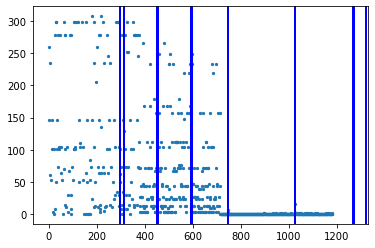

In [275]:
#plot p values
import matplotlib.pyplot as plt


neg_log_p_values = -1*np.log10(p_values_genome)


plt.scatter(range(len(neg_log_p_values)), neg_log_p_values, s = 5)
vert_line_pos = [int(e[3:]) for e in causal_variants] #[i for i, e in enumerate(['snp' + str(num1) for num1 in range(n_snps)]) if e in causal_variants]
for position in vert_line_pos:
    plt.axvline(x = position, color = 'b', label = 'axvline - full height')
# plt.show()
plt.savefig('simulated_p_values.png')

In [276]:
# fig = plt.figure()
# ax1 = fig.add_subplot(111)

# ax1.scatter(range(int(ld_blocks.loc[0, "start"]), int(ld_blocks.loc[len(ld_blocks)-1, "end"])),
#             neg_log_p_values,
#             s=10, c='b', marker="s", label='first')
# ax1.scatter(range(int(annotations.loc[0, "start"]), int(annotations.loc[len(annotations)-1, "end"])),
#             genome_scores,
#             s=10, c='r', marker="o", label='second')
# plt.legend(loc='upper left');
# plt.show()

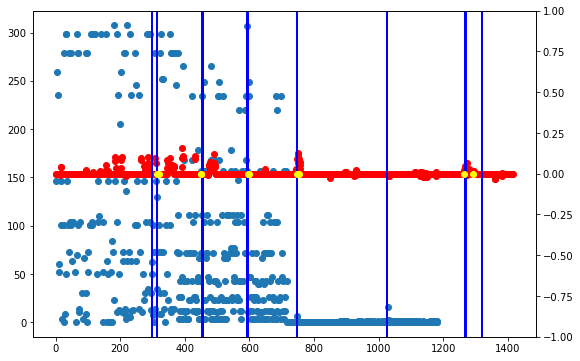

In [277]:
fig, ax1 = plt.subplots(figsize=(9, 6))

# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax2.set_ylim(-1, 1);

ax1.scatter(range(int(ld_blocks.loc[0, "start"]), int(ld_blocks.loc[len(ld_blocks)-1, "end"])), neg_log_p_values)
ax2.scatter(range(int(annotations.loc[0, "start"]), int(annotations.loc[len(annotations)-1, "end"])), genome_scores, c='r')
vert_line_pos = [int(e[3:]) for e in causal_variants] #[i for i, e in enumerate(['snp' + str(num1) for num1 in range(n_snps)]) if e in causal_variants]
for position in vert_line_pos:
    plt.axvline(x = position, color = 'b', label = 'axvline - full height')
    
    
for prior_causal_gene in prior_causal_genes:
    indices = annotations.index[annotations['gene_name'] == prior_causal_gene].tolist()
    y1 = y2 = 0
    x2 = annotations.loc[indices[len(indices)-1], 'end']
    x1 = annotations.loc[indices[0], 'start']
    plt.plot(x1, y1, x2, y2, marker = 'o', color = 'yellow')
    


In [238]:

# number_of_networks = len(networks)
# gene_list = list(annotations['gene_name'].unique())
# chromosome_list = list(annotations['chromosome'].unique())




# annotations = condense_annotations(annotations)
# networks = filter_network_genes(networks, annotations)


# #delete_me
# networks = [[prior_causal_genes], [prior_causal_genes]]


# print('done1')

# list_of_gene_of_source_gene, list_of_gene_of_destination_pathway = generate_gene_of_edges(networks, gene_list)
# list_of_network_source_gene, list_of_network_distination_gene = generate_network_edges(networks, gene_list)
# region_of_source_region, region_of_distination_gene = generate_region_of_edges(gene_list, annotations)
# same_gene_source_region, same_gene_destination_region = generate_same_gene_edges(annotations)
# overlapping_source_region, overlapping_destination_region = generate_overlapping_edges(annotations, chromosome_list)
# linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region = generate_linkage_disequilibrium_edges(ld_blocks, annotations)


# print('done2')
    

In [239]:

# probabilities, predicted_classes, dictionary_importance_scores = node_classification(summary_statistics,  number_of_networks, annotations, gene_list, encoder_ratio_denominator,
#                                                                                        linkage_disequilibrium_source_region, linkage_disequilibrium_destination_region, 
#                                                                                        overlapping_source_region, overlapping_destination_region, 
#                                                                                        same_gene_source_region, same_gene_destination_region, 
#                                                                                        region_of_source_region, region_of_distination_gene, 
#                                                                                        list_of_network_source_gene, list_of_network_distination_gene, 
#                                                                                        list_of_gene_of_source_gene, list_of_gene_of_destination_pathway)





In [240]:
# dictionary_importance_scores

In [241]:
with open('list_encoded_feature_matrices.pkl', 'rb') as inp:
    list_encoded_feature_matrices = pickle.load(inp)

In [242]:
list_encoded_feature_matrices

array([[ 0.        ,  0.        ,  1.        , ..., -0.1816583 ,
        -0.15739971,  0.39381   ],
       [ 0.        ,  0.        ,  1.        , ..., -0.13174081,
        -0.09440246,  0.52692401],
       [ 0.        ,  0.        ,  1.        , ..., -0.12342066,
         0.0540826 ,  0.9329139 ],
       ...,
       [ 0.        ,  0.        ,  1.        , ..., -0.15247041,
        -0.03431365,  0.92163265],
       [ 0.        ,  0.        ,  1.        , ..., -0.16901588,
        -0.2671302 , -0.21133207],
       [ 0.        ,  0.        ,  1.        , ..., -0.13969865,
        -0.05203493,  0.33996162]])

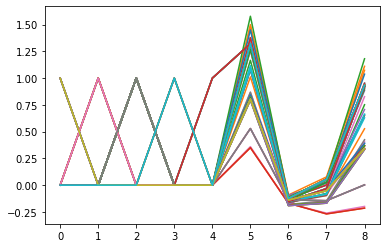

In [243]:
x = range(list_encoded_feature_matrices.shape[1])
plt.plot(x, list_encoded_feature_matrices[0:100,:].T)